# Several analysers of the classification model on many images of the LeafSnap30 data subset using iNNvestigate 

### Settings

In [49]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

### Load the data and split into train, test and validation

In [50]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Split the data into train and test sets

In [51]:
[images_train, _, images_test, 
 labels_one_hot_train, _, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
#print('Image size - valid. set: ', np.shape(images_val))
#print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    
nim_test = len(labels_one_hot_test)
print('Number of test images: ', nim_test)

Image size - train set:  (4295, 64, 64, 3)
Labels size - train set:  (4295, 30)
Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522
Number of test images:  614


In [52]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

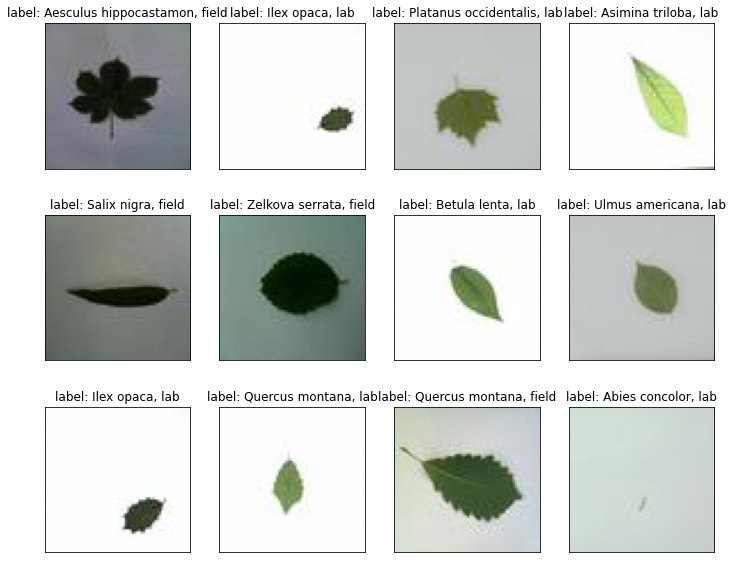

In [53]:
# plot random train images
d.plot_12images(images = images_train, labels = labels_train, sources = sources_train, figsize=(12,10))

### Data formatting

In [54]:
img_rows = 64
img_cols = 64
img_channels = 3

if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
   # images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
   # images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
#print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (4295, 64, 64, 3)
Size of testing data:  (614, 64, 64, 3)


## Model

In [55]:
# path of the Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')

# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 12)        912       
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 12)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 24)        7224      
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 24)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 24)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 4056)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 200)             

Evaluate on test images

In [56]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

Test loss: 0.8515864030157704
Test accuracy: 74.9185667946595 %


## Predicted classes

In [58]:
prediction_numeric = model.predict_classes(images_test)
print("Size of predictions: ", np.shape(prediction_numeric))
#strs = ["" for x in range(size)]
#prediction = np.zeros(nim_test)
predictions= pd.DataFrame({'prediction_numeric': prediction_numeric, 'true_label_numeric': labels_numeric_test, 'true_label': labels_test, 'source': sources_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction_numeric', 'true_label_numeric', 'true_label', 'source', 'filename', 'path']]
predictions.tail(400)


Size of predictions:  (614,)


,prediction_numeric,true_label_numeric,true_label,source,filename,path
5736,12,12,Quercus bicolor,field,1258491463_0000.jpg,dataset/images/field/quercus_bicolor/125849146...
5737,18,3,Betula lenta,lab,wb1193-10-1.jpg,dataset/images/lab/Auto_cropped/betula_lenta/w...
5738,15,29,Quercus montana,lab,pi0038-07-4.jpg,dataset/images/lab/Auto_cropped/quercus_montan...
5739,29,10,Platanus occidentalis,lab,pi0184-09-2.jpg,dataset/images/lab/Auto_cropped/platanus_occid...
5740,21,21,Ilex opaca,field,1259045059_0027.jpg,dataset/images/field/ilex_opaca/1259045059_002...
...,...,...,...,...,...,...
6131,15,15,Tilia americana,lab,pi0057-05-1.jpg,dataset/images/lab/Auto_cropped/tilia_american...
6132,3,3,Betula lenta,lab,wb1194-05-2.jpg,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,25,25,Ptelea trifoliata,lab,pi0005-05-3.jpg,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,22,23,Broussonettia papyrifera,lab,ny1124-02-2.jpg,dataset/images/lab/Auto_cropped/broussonettia_...


### Add  the species names to the predictions

In [59]:
# correspondence label and label_numeric
info_data_unique = info_data[['label', 'label_numeric']]
info_data_unique = info_data_unique.drop_duplicates(keep='first').sort_values('label_numeric').reset_index(drop=True)
info_data_unique.rename(columns={'label': 'unique_true_label', 'label_numeric':'unique_true_label_numeric'}, inplace = True)
info_data_unique.head(30)

,unique_true_label,unique_true_label_numeric
0,Acer campestre,0
1,Acer platanoides,1
2,Aesculus hippocastamon,2
3,Betula lenta,3
4,Betula nigra,4
5,Celtis occidentalis,5
6,Diospyros virginiana,6
7,Magnolia acuminata,7
8,Magnolia grandiflora,8
9,Platanus acerifolia,9


In [61]:
predictions_full = pd.merge(predictions,info_data_unique,left_on='prediction_numeric',
                            right_on='unique_true_label_numeric')
#predictions_full.shape
predictions_full.tail(400)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,unique_true_label,unique_true_label_numeric
214,12,12,Quercus bicolor,lab,wb1562-07-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
215,12,22,Acer rubrum,lab,pi2608-02-1.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...,Quercus bicolor,12
216,12,12,Quercus bicolor,field,1249317417_0001.jpg,dataset/images/field/quercus_bicolor/124931741...,Quercus bicolor,12
217,12,12,Quercus bicolor,lab,wb1563-02-3.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
218,12,12,Quercus bicolor,lab,wb1563-04-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
...,...,...,...,...,...,...,...,...
609,9,9,Platanus acerifolia,lab,ny1133-08-3.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia,9
610,9,9,Platanus acerifolia,lab,ny1133-01-4.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia,9
611,13,13,Quercus rubra,lab,pi1053-01-4.jpg,dataset/images/lab/Auto_cropped/quercus_rubra/...,Quercus rubra,13
612,13,13,Quercus rubra,field,1259041393_0019.jpg,dataset/images/field/quercus_rubra/1259041393_...,Quercus rubra,13


In [62]:
predictions_full.rename(columns={'unique_true_label': 'prediction_label'}, inplace = True)
predictions_full.tail(400)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,prediction_label,unique_true_label_numeric
214,12,12,Quercus bicolor,lab,wb1562-07-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
215,12,22,Acer rubrum,lab,pi2608-02-1.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...,Quercus bicolor,12
216,12,12,Quercus bicolor,field,1249317417_0001.jpg,dataset/images/field/quercus_bicolor/124931741...,Quercus bicolor,12
217,12,12,Quercus bicolor,lab,wb1563-02-3.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
218,12,12,Quercus bicolor,lab,wb1563-04-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor,12
...,...,...,...,...,...,...,...,...
609,9,9,Platanus acerifolia,lab,ny1133-08-3.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia,9
610,9,9,Platanus acerifolia,lab,ny1133-01-4.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia,9
611,13,13,Quercus rubra,lab,pi1053-01-4.jpg,dataset/images/lab/Auto_cropped/quercus_rubra/...,Quercus rubra,13
612,13,13,Quercus rubra,field,1259041393_0019.jpg,dataset/images/field/quercus_rubra/1259041393_...,Quercus rubra,13


In [63]:
predictions_full.drop('unique_true_label_numeric', axis=1, inplace=True)
predictions_full.tail(400)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,prediction_label
214,12,12,Quercus bicolor,lab,wb1562-07-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor
215,12,22,Acer rubrum,lab,pi2608-02-1.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...,Quercus bicolor
216,12,12,Quercus bicolor,field,1249317417_0001.jpg,dataset/images/field/quercus_bicolor/124931741...,Quercus bicolor
217,12,12,Quercus bicolor,lab,wb1563-02-3.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor
218,12,12,Quercus bicolor,lab,wb1563-04-2.jpg,dataset/images/lab/Auto_cropped/quercus_bicolo...,Quercus bicolor
...,...,...,...,...,...,...,...
609,9,9,Platanus acerifolia,lab,ny1133-08-3.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia
610,9,9,Platanus acerifolia,lab,ny1133-01-4.jpg,dataset/images/lab/Auto_cropped/platanus_aceri...,Platanus acerifolia
611,13,13,Quercus rubra,lab,pi1053-01-4.jpg,dataset/images/lab/Auto_cropped/quercus_rubra/...,Quercus rubra
612,13,13,Quercus rubra,field,1259041393_0019.jpg,dataset/images/field/quercus_rubra/1259041393_...,Quercus rubra


### Visualize some predictions 

In [ ]:
# display 12 random images and display their predictions
predictions_numeric_test = predictions['prediction_numeric']
d.plot_12images(images = images_test, labels = labels_test, predictions = predictions_numeric_test, sources = sources_test, figsize=(12,10))